In [1]:
import numpy as np
import matplotlib.pyplot as plt
from GEM import GEM

save = False


We will use the pomegranate package, because it provides very good functionality for mixture models.

In [2]:
from pomegranate import *


# Generate Mock Data

Observations $\theta_k\in\Theta$ are drawn from the "true" distribution $G_*$, which is here taken to be a log-normal;
$$ \theta_k \sim G_*\quad\mathrm{for}\;k=1,2,\ldots, n. $$

(The log-normal distribution only has support on the postive real line; however, we will pretend we don't know this _a priori_ and continue to work on the whole real line, $\Theta=\mathbb{R}$.)

The observed distribution is just a sum of equally-weighted delta-functions,
$$ G_{\rm obs} = \frac{1}{n}\sum_{i=1}^{n}\delta_{\theta_i}. $$

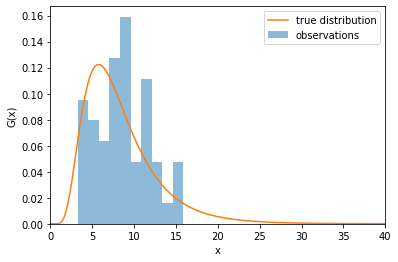

In [3]:
true_dist = LogNormalDistribution(2, 0.5)

# generate mock observations
n = 50
observations = true_dist.sample(n)

# the observed distribution is just a sum of delta-functions
observed_dist = DiscreteDistribution(dict(zip(observations, np.ones(n)/n)))


plt.hist(observations, density=True, alpha=0.5, label='observations')

x = np.linspace(0, 40, 1000)
plt.plot(x, true_dist.probability(x), label='true distribution')

plt.xlabel("x")
plt.ylabel("G(x)")
plt.xlim(0, 40)
plt.legend()
if save:
    plt.savefig("mock_data.png")
    plt.clf()
else:
    plt.show()


# Density Estimation: Fixed Hyperparameters

First, let's perform density estimation with a fixed concentration parameter and base distribution;
$$ \alpha = 4 $$
$$ H = \mathcal{N}(\mu=5, \sigma=3). $$
 
The posterior on the density is
$$ G|\vec{\theta}\sim\mathrm{DP}\bigg(\alpha+n,\frac{\alpha H + \sum_{i=1}^{n}\delta(x-\theta_i)}{\alpha+n}\bigg). $$


In [4]:
alpha = 4.

# Number of posterior draws
N = 300

print(f"We should choose K >> {(alpha+n)*np.log(1+N/(alpha+n)):.2f}")

We should choose K >> 101.54


In [5]:
# Number of clusters
K = 400

# Hyperparameter priors
H = NormalDistribution(8, 4)

# Stick-breaking construction for the weights
pi_k = GEM(alpha+len(observations), K=K, N=N)

# The atoms
base = GeneralMixtureModel([H, observed_dist], weights=[alpha/(alpha+n), n/(alpha+n)])
phi_k = base.sample(K*N).reshape((K, N))


Note that draws from the posterior distribution are always discrete. 
This might seem strange at first; it takes a bit of getting used to.

One practical problem is visualing discrete distributions. Because in this simple problem $\Theta=\mathbb{R}$ we can visualise the CDF instead, which is smoother.

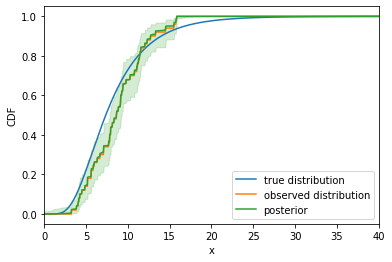

In [6]:
x = np.linspace(0, 40, 1000)[1:]
dx = np.mean(np.diff(x))

plt.plot(x, np.cumsum(dx*true_dist.probability(x)), color='C0', label="true distribution")

plt.plot(x, np.mean((np.repeat(observations[np.newaxis], len(x), axis=0).T<x), axis=0), 
          color='C1', label='observed distribution')

mask = np.repeat(phi_k[...,np.newaxis], len(x), axis=-1) < x
vals = np.sum(np.repeat(pi_k[...,np.newaxis], len(x), axis=-1)*mask, axis=0)
percentiles = np.percentile(vals, [5, 50, 95], axis=0)
plt.plot(x, percentiles[1], color='C2', label='posterior')
plt.fill_between(x, percentiles[0], percentiles[2], color='C2', alpha=0.2)

plt.xlabel("x")
plt.ylabel("CDF")
plt.xlim(0, 40)
plt.legend()
if save:
    plt.savefig("fixed_hyperparams_cdf.png")
    plt.clf()
else:
    plt.show()


Plotting the CDF is OK. However, it is only a option in 1 dimension. In general we need another solution for visualising the density.

One practical way to get a smooth distribution is to convolve with a kernel function. For example, in this problem we might use a Gaussian kernel,
$$ k(x) = \frac{\exp\left(\frac{-x^2}{2b^2}\right)}{\sqrt{2\pi b^2}} . $$

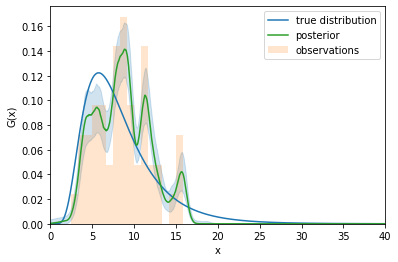

In [7]:
# The kernel
def density_posterior(x, atoms, kernel_bw=1, percentile=[5, 50, 95]): 
    X = x
    for size in phi_k.shape:
        X = np.repeat(X[..., np.newaxis], size, axis=-1)
    return np.percentile(np.mean(
                        np.exp(-0.5*((X-atoms)/kernel_bw)**2)/np.sqrt(2*np.pi*kernel_bw**2), axis=-1), 
                        percentile, axis=-1)

plt.plot(x, true_dist.probability(x), color='C0', ls='-', label='true distribution')

plt.hist(observations, bins=np.linspace(0, max(observations), 20), color='C1', 
         density=True, alpha=0.2, label='observations')

b = n**(-1/4) # Scott's rule
G = density_posterior(x, phi_k, kernel_bw=1.4*b)
plt.plot(x, G[1,:], label='posterior', c='C2')
plt.fill_between(x, G[0,:], G[2,:], alpha=0.2, color='C0')

plt.xlabel("x")
plt.ylabel("G(x)")
plt.xlim(0, 40)
plt.legend()
if save:
    plt.savefig("fixed_hyperparams_pdf.png")
    plt.clf()
else:
    plt.show()


The above densitty estimation works quite well. but this is only because we chose the parameter $\alpha$ and $H$ carefully. We should marginalise over these parameters.


# Density Estimation: Marginalised Hyperparameters

Place a Gamma prior on the DP concentration parameter,
$$ \alpha \sim \mathrm{Gamma}(4, 1/2). $$

Again, we use a Gaussian as the base distribution, $H=\mathcal{N}(\mu, \sigma^2)$, and place priors over the mean and variance,
$$ \mu \sim \mathcal{N}(\mu=10, \sigma=4), $$
$$ \sigma \sim \mathrm{Gamma}(3, 1). $$

First we define the _hyperlikelihood_ $P(\vec{\theta}|\alpha,H)$. This can also be thought of as the evidence for a DP analysis with fixed hyperparameters.

In [8]:
from scipy.special import loggamma

def log_likelihood(alpha, mu, sigma, observations):
    """
    The hyperlikelihood P(\vec{\theta}|\alpha, H)
    where H is parametrised by \mu and \sigma 
    and \vec{\theta} are the observations
    """
    n = len(observations)
    ans = n*np.log(alpha) + loggamma(alpha) - loggamma(alpha+n)
    
    H = NormalDistribution(mu, sigma)
    ans += np.sum(H.log_probability(observations))
    
    return ans
                

Now we sample the hyperlikelihood. Here we do this using the _emcee_ package.

In [9]:
import emcee

# define the hyperpriors
pi_alpha = GammaDistribution(4., 0.5)
pi_mu = NormalDistribution(10., 4.)
pi_sigma = GammaDistribution(3., 1.)

def log_prior(alpha, mu, sigma):
    log_p = pi_alpha.log_probability(alpha)
    log_p += pi_mu.log_probability(mu)
    log_p += pi_sigma.log_probability(sigma)
    return log_p

def log_prob(x, obs):
    alpha, mu, sigma = tuple(x)
    
    # enforce prior boundaries
    if (alpha<=0) or (sigma<=0):
        return -np.inf
    
    else:    
        return log_likelihood(alpha, mu, sigma, obs) + log_prior(alpha, mu, sigma)

    
# initialise walker positions from the priors
ndim, nwalkers = 3, 100
p0 = np.vstack((pi_alpha.sample(nwalkers), 
                pi_mu.sample(nwalkers), 
                pi_sigma.sample(nwalkers))).T

# run a short burnin
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[observations])
state = sampler.run_mcmc(p0, 100)

sampler.reset()

# run the main analysis
sampler.run_mcmc(state, 10000)

# check chain is sufficiently long
auto_corr_len = int(np.mean(sampler.get_autocorr_time()))
print(f"auto correlation length = {auto_corr_len}")

# thin the posterior chain
samples = sampler.get_chain(flat=True)
samples = samples[::(2*auto_corr_len), :]


auto correlation length = 38


Plot the posteriors on the hyperparameters. This step is not necessary, but it's nice to help visualise what is going on.

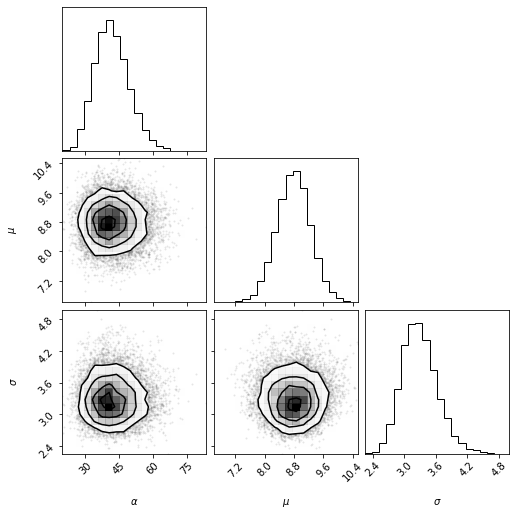

In [10]:
from corner import corner 

corner(samples, labels=[r'$\alpha$', r'$\mu$', r'$\sigma$'])
plt.show()


Now draw DP weights (GEM) and atoms from the DP mixture distribution.

In [11]:
random_indices = np.random.choice(np.arange(len(samples)), size=N, replace=False)
downsample = samples[random_indices]

# Stick-breaking construction for the weights
alpha = downsample[:,0]
pi_k = GEM(alpha+len(observations), K=K)

# The atoms
mu, sigma = downsample[:,1], downsample[:,2]
phi_k = np.zeros((K, N))
for i in range(N):
    H = NormalDistribution(mu[i], sigma[i])
    base = GeneralMixtureModel([H, observed_dist], weights=[alpha[i]/(alpha[i]+n), n/(alpha[i]+n)])
    phi_k[:,i] = base.sample(K)


As we did previously with the fixed hyperparameters, we can either visualise the results using the CDF...

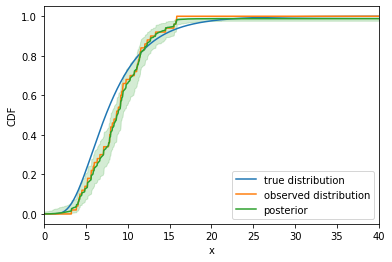

In [12]:
x = np.linspace(0, 40, 1000)[1:]
dx = np.mean(np.diff(x))

plt.plot(x, np.cumsum(dx*true_dist.probability(x)), color='C0', label="true distribution")

plt.plot(x, np.mean((np.repeat(observations[np.newaxis], len(x), axis=0).T<x), axis=0), 
          color='C1', label='observed distribution')

mask = np.repeat(phi_k[...,np.newaxis], len(x), axis=-1) < x
vals = np.sum(np.repeat(pi_k[...,np.newaxis], len(x), axis=-1)*mask, axis=0)
percentiles = np.percentile(vals, [5, 50, 95], axis=0)
plt.plot(x, percentiles[1], color='C2', label='posterior')
plt.fill_between(x, percentiles[0], percentiles[2], color='C2', alpha=0.2)

plt.xlabel("x")
plt.ylabel("CDF")
plt.xlim(0, 40)
plt.legend()
if save:
    plt.savefig("marg_hyperparams_cdf.png")
    plt.clf()
else:
    plt.show()


... or the PDF.

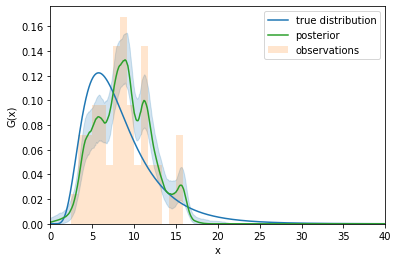

In [13]:
plt.plot(x, true_dist.probability(x), color='C0', ls='-', label='true distribution')

plt.hist(observations, bins=np.linspace(0, max(observations), 20), color='C1', 
         density=True, alpha=0.2, label='observations')

b = n**(-1/4) # Scott's rule
G = density_posterior(x, phi_k, kernel_bw=1.4*b)
plt.plot(x, G[1,:], label='posterior', c='C2')
plt.fill_between(x, G[0,:], G[2,:], alpha=0.2, color='C0')

plt.xlabel("x")
plt.ylabel("G(x)")
plt.xlim(0, 40)
plt.legend()
if save:
    plt.savefig("marg_hyperparams_pdf.png")
    plt.clf()
else:
    plt.show()
